<a href="https://colab.research.google.com/github/silverstar0727/NLP_study/blob/main/ch4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/My Drive/kaggle_nlp

/content/drive/My Drive/kaggle_nlp


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [ ]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
# 읽기 전용으로 데이터 로드
DATA_IN_PATH = 'after_preprocessing/'

train_input = np.load(open(DATA_IN_PATH + 'train_input.npy', 'rb'))
train_input = pad_sequences(train_input, maxlen = train_input.shape[1])

train_label = np.load(open(DATA_IN_PATH + 'train_label.npy', 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + 'data_configs.json', 'r'))

In [ ]:
# 모델 하이퍼 파라미터 정의
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

In [ ]:
# 구현
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
# model 생성
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = 'output/' + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

output/rnn_classifier_en -- Folder already exists 



In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5053
Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to output/rnn_classifier_en/weights.h5
176/176 [==============================] - 20s 113ms/step - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5345
Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to output/rnn_classifier_en/weights.h5
176/176 [==============================] - 19s 106ms/step - loss: 0.6805 - accuracy: 0.5345 - val_loss: 0.4860 - val_accuracy: 0.7576
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8566
Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to output/rnn_classifier_en/weights.h5
176/176 [==============================] - 19s 110ms/step - loss: 0.3408 - accuracy: 0.8566 - val_loss: 0.2773 - v

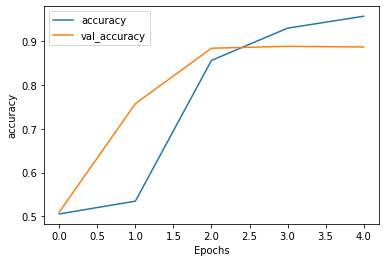

In [ ]:
plot_graphs(history, 'accuracy')

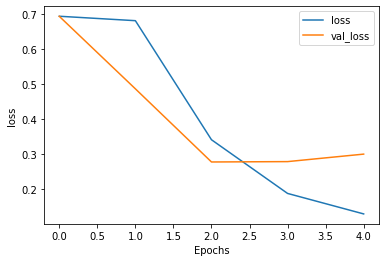

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
# test data load
test_input = np.load(open('after_preprocessing/test_input.npy', 'rb'))
test_input = pad_sequences(test_input, maxlen = test_input.shape[1])

In [ ]:
# best model load
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join('output/', SAVE_FILE_NM))

In [ ]:
# predict
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

InvalidArgumentError: ignored

In [ ]:
test_id = 